In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [3]:
import os
import pandas as pd
import math
import numpy as np

### Dataframes

In [4]:
REPOSITORY_PREFIX = 'https://raw.githubusercontent.com/RonildoSilva/datasets/main/'

In [5]:
# SFZ - Alimentos Congeneres
df_train = pd.read_csv(REPOSITORY_PREFIX+'df_train_keras_tk_reg_al_cg_prefix.csv')
df_val = pd.read_csv(REPOSITORY_PREFIX+'df_val_keras_tk_reg_al_cg_prefix.csv')
df_test = pd.read_csv(REPOSITORY_PREFIX+'df_test_keras_tk_reg_al_cg_prefix.csv')

In [6]:
df_train.columns

Index(['CaseID', 'Activity', 'Duration', 'Timestamp', 'Duration Float',
       'Time to conclusion', 'Passed Time', 'Step', 'Prefix', 'Activity Cat'],
      dtype='object')

In [7]:
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

14495 5688 5502


In [8]:
#df_train = df_train.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})
#df_val = df_val.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})
#df_test = df_test.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})

In [9]:
df_train = df_train[df_train['Time to conclusion'] != 0]
df_val = df_val[df_val['Time to conclusion'] != 0]
df_test = df_test[df_test['Time to conclusion'] != 0]

313 164 156


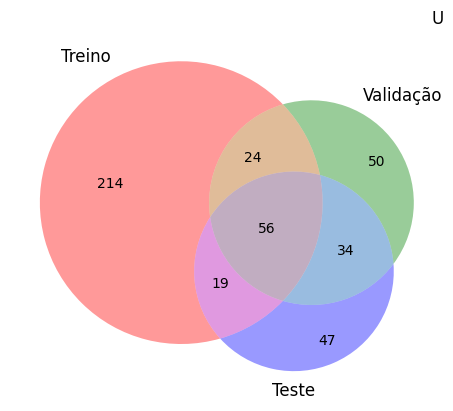

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Import the library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set_train = set(df_train['Activity Cat'].unique())
set_val = set(df_val['Activity Cat'].unique())
set_test = set(df_test['Activity Cat'].unique())

print(
    len(set_train),
    len(set_val),
    len(set_test)
)

z = set_test.intersection(set_val).intersection(set_train)

w = set_train.intersection(set_val).difference(z)
x = set_val.intersection(set_test).difference(z)
y = set_test.intersection(set_train).difference(z)

a = set_train.difference(w.union(z).union(y))
b = set_val.difference(w.union(x).union(z))
c = set_test.difference(z.union(x).union(y))


l_a = len(a)
l_b = len(b)
l_c = len(c)
l_w = len(w)
l_x = len(x)
l_z = len(z)
l_y = len(y)

# Make the diagram
venn3(subsets = (l_a, l_b, l_w, l_c, l_y,l_x, l_z),
      set_labels = ('Treino', 'Validação', 'Teste'))
plt.title('U', loc='right')
plt.savefig('reg_a75_venn.pdf', bbox_inches='tight')
plt.show()

from google.colab import files
files.download('reg_a75_venn.pdf')

In [11]:
print(df_train['Time to conclusion'].std(),
df_val['Time to conclusion'].std(),
df_test['Time to conclusion'].std())

109.52826374667757 89.61941389322281 89.67646037378331


In [12]:
#len(df_test['Case ID'].unique())

In [13]:
MAX_LEN_TRACE_TRAIN = df_train['Step'].max()

In [14]:
df_test['Step'].max()

49

### Features extraction

In [15]:
from keras.preprocessing.text import Tokenizer

### Features selection

In [ ]:
MAX_LEN = max(max(df_train['Step']),max(df_val['Step']),max(df_test['Step']))

In [ ]:
df_prefix_train = df_train['Prefix'].str.split(',', expand = True)
col = df_prefix_train.shape[1]
for i in range(MAX_LEN - df_prefix_train.shape[1]):
    df_prefix_train.insert(df_prefix_train.shape[1], col+i, None)
    #print(i)

In [ ]:
df_prefix_val = df_val['Prefix'].str.split(',', expand = True)
col = df_prefix_val.shape[1]
for i in range(MAX_LEN - df_prefix_val.shape[1]):
    df_prefix_val.insert(df_prefix_val.shape[1], col+i, None)
    #print(i)

In [ ]:
df_prefix_test = df_test['Prefix'].str.split(',', expand = True)
col = df_prefix_test.shape[1]
for i in range(MAX_LEN - df_prefix_test.shape[1]):
    df_prefix_test.insert(df_prefix_test.shape[1], col+i, None)
    #print(i)

In [ ]:
df_prefix_train = df_prefix_train.fillna('')
df_prefix_val = df_prefix_val.fillna('')
df_prefix_test = df_prefix_test.fillna('')

In [ ]:
tokenize_mode = 'sequences_to_matrix'

In [ ]:
kerasTokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=",")


train_txt = df_train['Activity'].values
val_txt = df_val['Activity'].values
test_txt = df_test['Activity'].values

kerasTokenizer.fit_on_texts(train_txt)

train_sequences = kerasTokenizer.texts_to_sequences(train_txt)
val_sequences = kerasTokenizer.texts_to_sequences(val_txt)
test_sequences = kerasTokenizer.texts_to_sequences(test_txt)

train_matrix = kerasTokenizer.texts_to_matrix(train_txt, mode='binary')
val_matrix = kerasTokenizer.texts_to_matrix(val_txt, mode='binary')
test_matrix = kerasTokenizer.texts_to_matrix(test_txt, mode='binary')


train_sequences_matrix = kerasTokenizer.sequences_to_matrix(train_sequences, mode='binary')
val_sequences_matrix = kerasTokenizer.sequences_to_matrix(val_sequences, mode='binary')
test_sequences_matrix = kerasTokenizer.sequences_to_matrix(test_sequences, mode='binary')

Text to sequences

In [ ]:
df_train_sequences = pd.DataFrame(train_sequences).fillna(0).astype(int)
col = df_train_sequences.shape[1]
for i in range(MAX_LEN - df_train_sequences.shape[1]):
    df_train_sequences.insert(df_train_sequences.shape[1], col+i, 0)
    #print(i)


df_test_sequences = pd.DataFrame(test_sequences).fillna(0).astype(int)
col = df_test_sequences.shape[1]
for i in range(MAX_LEN - df_test_sequences.shape[1]):
    df_test_sequences.insert(df_test_sequences.shape[1], col+i, 0)
    #print(i)

df_val_sequences = pd.DataFrame(val_sequences).fillna(0).astype(int)
col = df_val_sequences.shape[1]
for i in range(MAX_LEN - df_val_sequences.shape[1]):
    df_val_sequences.insert(df_val_sequences.shape[1], col+i, 0)
    #print(i)


In [ ]:
if(tokenize_mode == 'sequences_to_matrix'):
    X_train = np.concatenate((df_train[['Step', 'Duration Float', 'Passed Time']].values,
                              train_sequences_matrix), axis=1)
    y_train = df_train[['Time to conclusion']].values

    X_test = np.concatenate((df_test[['Step', 'Duration Float', 'Passed Time']].values,
                             test_sequences_matrix), axis=1)
    y_test = df_test[['Time to conclusion']].values


    X_val = np.concatenate((df_val[['Step', 'Duration Float', 'Passed Time']].values,
                            val_sequences_matrix), axis=1)
    y_val = df_val[['Time to conclusion']].values

In [ ]:
X_train_ml = np.concatenate((X_train, X_val), axis=0)
y_train_ml = np.concatenate((y_train, y_val), axis=0)

In [ ]:
print(X_train.shape)

(13655, 101)


In [ ]:
print(X_train_ml.shape)

(19063, 101)


### ML Experiment

In [ ]:
! pip install lightgbm
! pip install xgboost

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import lightgbm as ltb

regressors = [
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)},
        {'nome': 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, max_features='auto',
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
        {'nome' : 'XGBoostRegressor', 'regressor': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)},
        {'nome' : 'LightGBM Regressor', 'regressor': ltb.LGBMRegressor(random_state=0)}
]

In [ ]:
import numpy as np
import scipy.stats as st

def ci(data):
  #create 95% confidence interval for population mean weight
  return st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


import time
from sklearn.metrics import mean_absolute_error
from google.colab import files

cols = [
        'Nome do modelo', 'MAE', 'CI'
       ]

data_result = []

if(2>3):
  for regressor in regressors:
      t1 = time.time()
      if(regressor['nome'] == 'LightGBM Regressor'):
        regr = regressor['regressor'].fit(X_train_ml, y_train_ml, categorical_feature=[i for i in range(0,MAX_LEN_TRACE_TRAIN+1)])
      else:
        regr = regressor['regressor'].fit(X_train_ml, y_train_ml)
      tf = time.time()

      y_pred = regr.predict(X_test)
      mae = mean_absolute_error(y_test, y_pred)

      y_t = []

      for t in y_test:
        cur_t = str(t)
        str_v = cur_t.replace('[','')
        str_v = str_v.replace(']','')
        y_t.append(float(str_v))


      int_conf = ci(abs(y_t - np.squeeze(y_pred)))

      line = [
          regressor['nome'],
          mae,
          int_conf
      ]

      data_result.append(line)

      df_results = pd.DataFrame(list(zip(y_test, np.squeeze(y_pred))),columns =['y_test', 'y_pred'])
      df_results.to_csv('Baseline AL_CG_'+regressor['nome']+'.csv', index=False)
      files.download('Baseline AL_CG_'+regressor['nome']+'.csv')

  pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True).to_csv('Baseline AL_CG_.csv')
  files.download('Baseline AL_CG_.csv')

### Deep learning Experiment

Deep learning model definition

In [ ]:
#! pip install keras_self_attention

In [ ]:
#from keras_self_attention import SeqSelfAttention

In [ ]:
import keras

from tensorflow import keras
import tensorflow as tf

from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Masking

from tensorflow.keras.layers import concatenate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback


from keras.layers.core import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [ ]:
df_train['Step'].max()

60

In [ ]:
df_val['Step'].max()

69

In [ ]:
df_test['Step'].max()

49

In [ ]:
TIME_COLS = ['Duration Float', 'Passed Time', 'Step']

In [ ]:
dl_x_train = train_sequences_matrix
dl_x_val = val_sequences_matrix
dl_x_test = test_sequences_matrix

In [ ]:
dl_x_t_train = df_train[TIME_COLS].values
dl_x_t_val = df_val[TIME_COLS].values
dl_x_t_test = df_test[TIME_COLS].values

In [ ]:
dl_x_train = dl_x_train.reshape(dl_x_train.shape[0], dl_x_train.shape[1], 1)
dl_x_val = dl_x_val.reshape(dl_x_val.shape[0], dl_x_val.shape[1], 1)
dl_x_test = dl_x_test.reshape(dl_x_test.shape[0], dl_x_test.shape[1], 1)

In [ ]:
dl_x_t_train = dl_x_t_train.reshape(dl_x_t_train.shape[0], dl_x_t_train.shape[1], 1)
dl_x_t_val = dl_x_t_val.reshape(dl_x_t_val.shape[0], dl_x_t_val.shape[1], 1)
dl_x_t_test = dl_x_t_test.reshape(dl_x_t_test.shape[0], dl_x_t_test.shape[1], 1)

In [ ]:
print(dl_x_train.shape, dl_x_t_train.shape)

(13655, 98, 1) (13655, 3, 1)


In [ ]:
n_activities = len(pd.concat([df_train, df_val, df_test], ignore_index=True)['Activity Cat'].unique())

In [ ]:
n_activities

444

In [ ]:
shape = train_sequences_matrix.shape[1]
shape_t = len(TIME_COLS)

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.


In [ ]:
! pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=28cb8a0ef896fef11b60f342b34a0fe3c988182bf04c8ce1b4ad9e5c7092cf27
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

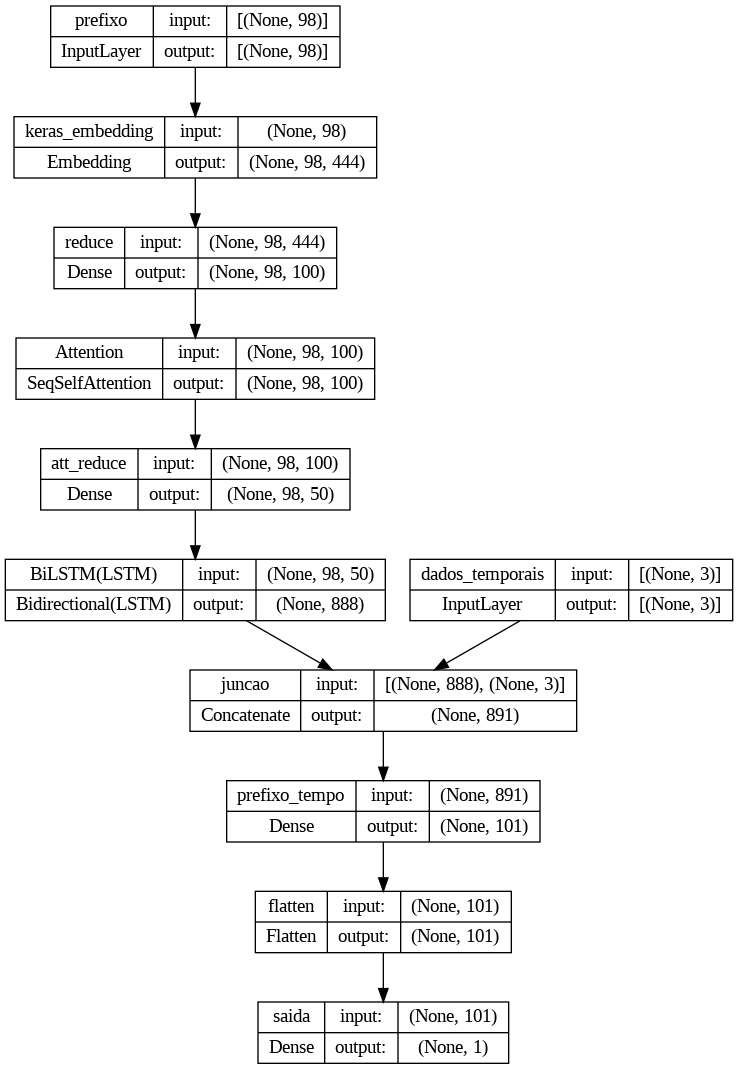

In [ ]:
seq_length = shape
seq_length_t = shape_t

input_dim = n_activities + 1

activity_input = Input(shape=(seq_length,), name='prefixo')
time_input = Input(shape=(shape_t,), name='dados_temporais')

embedding_size = n_activities

embedding = Embedding(output_dim=embedding_size,
                      input_dim=input_dim,
                      input_length=seq_length,
                      name='keras_embedding')(activity_input)

#
embedding = Dense(100, name='reduce')(embedding)

att = SeqSelfAttention(
    attention_width=embedding_size,
    attention_activation='relu',
    name='Attention')(embedding)

#
att = Dense(50, name='att_reduce')(att)

rnn = Bidirectional(LSTM(embedding_size,
                            dropout=0.1,
                            recurrent_dropout=0.1,
                            kernel_regularizer=keras.regularizers.l2(0.01), name='LSTM'),
                       name='BiLSTM')(att)


x = concatenate([rnn, time_input], name='juncao')

x = Dense((seq_length + seq_length_t),
          activation='relu',
          name='prefixo_tempo')(x)

x = Flatten()(x)
x = Dense(1, activation='linear', name='saida')(x)

model = Model(inputs=[activity_input , time_input], outputs=[x])

#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.7, beta_2=0.9, epsilon=1e-07, name="Nadam")

adam = keras.optimizers.Nadam(learning_rate=0.01, epsilon=0.01)

model.compile(
    optimizer=nadam,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error',
                   min_delta=1e-07, #min_delta=1e-04,
                   patience=5, verbose=1)

history = model.fit([dl_x_train, dl_x_t_train], y_train,
                    epochs=150,
                    batch_size=150,
                    callbacks=[TqdmCallback(verbose=0), es],
                    validation_data=[[dl_x_val, dl_x_t_val], y_val],
                    verbose=0)

0epoch [00:00, ?epoch/s]

Epoch 91: early stopping


Loss

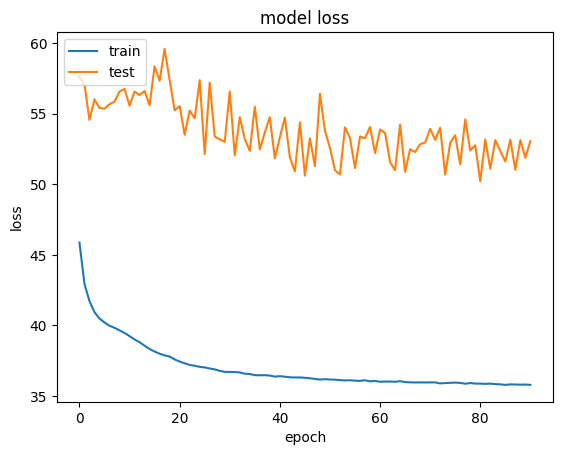

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predicton = model.predict([dl_x_test,dl_x_t_test])

164/164 [==============================] - 11s 64ms/step


In [ ]:
test_predicton.shape

(5222, 1)

In [ ]:
y_test.shape

(5222, 1)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mae_error = mean_absolute_error(y_test, test_predicton)

In [ ]:
y_t = []

for t in y_test:
  cur_t = str(t)
  str_v = cur_t.replace('[','')
  str_v = str_v.replace(']','')
  y_t.append(float(str_v))

int_conf = ci(abs(y_t - np.squeeze(test_predicton)))

print('ci: ' , mae_error, int_conf)

ci:  52.08062681427734 (50.11252961771898, 54.0487240108357)


CSV resultados pred x real

In [ ]:
from google.colab import files

df_results = pd.DataFrame(list(zip(y_test, np.squeeze(test_predicton))),columns =['y_test', 'y_pred'])
df_results.to_csv('A) AL_CG_SA_BiLSTM_PRED_REAL.csv', index=False)

files.download('A) AL_CG_SA_BiLSTM_PRED_REAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Avaliação por etapa

In [ ]:
MAX_STEP = df_test['Step'].max()

In [ ]:
MAX_STEP

49

In [ ]:
df_test['Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [ ]:
df_full_test = pd.DataFrame(dl_x_test.reshape(dl_x_test.shape[0], (dl_x_test.shape[1]*dl_x_test.shape[2])))
df_full_test['Step'] = df_test['Step']
df_full_test['Time to conclusion'] = df_test['Time to conclusion']

In [ ]:
dl_full_t_test = pd.DataFrame(dl_x_t_test.reshape(dl_x_t_test.shape[0], (dl_x_t_test.shape[1]*dl_x_t_test.shape[2])))
dl_full_t_test['Step'] = df_test['Step']

In [ ]:
step = list()
mae = list()

for i in range(1, MAX_STEP+1):
  dl_x__local_test = df_full_test[df_full_test['Step'] == i]
  ACT_COLS = dl_x__local_test.columns.tolist()
  ACT_COLS.remove('Step')
  ACT_COLS.remove('Time to conclusion')
  x_local = dl_x__local_test[ACT_COLS].values

  dl_x_t_local_test = dl_full_t_test[dl_full_t_test['Step'] == i]
  TIME_COLS = dl_x_t_local_test.columns.tolist()
  TIME_COLS.remove('Step')
  x_t_local = dl_x__local_test[TIME_COLS].values

  print(dl_x_t_local_test.shape)

  y_local_test = df_full_test[df_full_test['Step'] == i]['Time to conclusion']
  local_test_predicton = model.predict([[x_local, x_t_local]])

  mae_error = mean_absolute_error(y_local_test, local_test_predicton)

  mae.append(mae_error)
  step.append(i)

(259, 4)
9/9 [==============================] - 1s 62ms/step
(259, 4)
9/9 [==============================] - 1s 61ms/step
(259, 4)
9/9 [==============================] - 1s 90ms/step
(259, 4)
9/9 [==============================] - 1s 89ms/step
(259, 4)
9/9 [==============================] - 1s 87ms/step
(258, 4)
9/9 [==============================] - 1s 59ms/step
(257, 4)
9/9 [==============================] - 1s 58ms/step
(256, 4)
8/8 [==============================] - 0s 59ms/step
(256, 4)
8/8 [==============================] - 1s 62ms/step
(253, 4)
8/8 [==============================] - 0s 60ms/step
(250, 4)
8/8 [==============================] - 0s 57ms/step
(247, 4)
8/8 [==============================] - 0s 59ms/step
(242, 4)
8/8 [==============================] - 0s 60ms/step
(225, 4)
8/8 [==============================] - 0s 59ms/step
(204, 4)
7/7 [==============================] - 0s 59ms/step
(182, 4)
6/6 [==============================] - 0s 58ms/step
(159, 4)
5/5 [==========

In [ ]:
for s, m in zip(step,mae):
  print(s,m)

1 91.19340371301128
2 91.33821517946691
3 74.89303921751517
4 64.4328532560724
5 58.41117219898121
6 58.27459444565883
7 57.304255044163796
8 56.627513155269625
9 57.788207679224016
10 59.79218785964906
11 63.926021180908194
12 67.90986831983807
13 70.19259878645968
14 71.10612388547091
15 70.85205770413268
16 72.73557804719695
17 74.22200101157135
18 73.87558446186452
19 69.41182002504063
20 66.58518121826174
21 66.79055686693691
22 66.8600212903771
23 68.5550596385035
24 70.4559854868571
25 72.87649414488328
26 72.9435258478655
27 75.04870455991686
28 75.70750553776666
29 72.29677640593155
30 73.98474243919735
31 73.30962729779412
32 76.81508781433106
33 78.38885571289063
34 80.41153998325892
35 79.98798529866536
36 78.71242037702288
37 80.18766927001954
38 77.79456639404297
39 77.79712639404296
40 79.0675617126465
41 81.83370533447265
42 82.81067200113932
43 83.77740533447266
44 83.78700533447265
45 83.83410533447265
46 84.94437528076172
47 85.18183759765625
48 85.87553759765625
49 

In [ ]:
for s, m in zip(step,mae):
  print(str(round(m, 4)).replace('.',','))

91,1934
91,3382
74,893
64,4329
58,4112
58,2746
57,3043
56,6275
57,7882
59,7922
63,926
67,9099
70,1926
71,1061
70,8521
72,7356
74,222
73,8756
69,4118
66,5852
66,7906
66,86
68,5551
70,456
72,8765
72,9435
75,0487
75,7075
72,2968
73,9847
73,3096
76,8151
78,3889
80,4115
79,988
78,7124
80,1877
77,7946
77,7971
79,0676
81,8337
82,8107
83,7774
83,787
83,8341
84,9444
85,1818
85,8755
73,674


In [ ]:
np.mean(mae)

73.76699532968111